# Importando os dados

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.svm import SVC
import numpy as np
from sklearn.impute import SimpleImputer
from sklvq import GLVQ
import matplotlib.pyplot as plt


from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('dataset.csv')
df = df.replace('?', np.nan)
df = df.sample(frac = 0.005, random_state = 5).reset_index(drop=True)

<positron-console-cell-2>:1: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
X = df.loc[:, df.columns != 'SepsisLabel']
nomes_colunas = X.columns
y = df['SepsisLabel']

# Dividindo os dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 5)

# KNN

In [5]:
# Criando a Pipeline
pipeline_steps_knn = [
    ('imputer', SimpleImputer()), # Imputando dados 
    ('smote', SMOTE(random_state = 5)), # Reamostragem 
    ('scaler', StandardScaler()),       
    ('classifier', KNeighborsClassifier()) # Modelo 
]

pipeline_knn = ImbPipeline(pipeline_steps_knn)

In [13]:
knn_param_dist = {
    'imputer__strategy': ['mean', 'median'],

    # parametros do SMOTE
    # numero de vizinhos para gerar amostras
    'smote__k_neighbors': [3,5,7,9],

    # parametros do knn
    'classifier__n_neighbors': np.arange(1,10),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['minkowski'],
    'classifier__p': [1, 2, 3]
}

In [59]:
best_score_overall = -1
best_params_overall = None
best_model_overall = None
historicos_knn_cv = []

for c in range(1, 21):
    print(f'Execução de RandomizedSearchCV {c}/20')
    current_knn_cv = RandomizedSearchCV(
        estimator=pipeline_knn,
        param_distributions=knn_param_dist,
        n_iter=5, 
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=c),
        scoring='f1',
        verbose=0,
        n_jobs=-1
    )
    current_knn_cv.fit(X_train, y_train)

    resultados_knn_iter = current_knn_cv.cv_results_
    historico_knn_df_iter = pd.DataFrame({
        'params': resultados_knn_iter['params'],
        'mean_test_score': resultados_knn_iter['mean_test_score'],
        'std_test_score': resultados_knn_iter['std_test_score'],
        'rank_test_score': resultados_knn_iter['rank_test_score']
    })

    historico_knn_df_iter['run_iteration'] = c
    historicos_knn_cv.append(historico_knn_df_iter)


    
    if current_knn_cv.best_score_ > best_score_overall:
        best_score_overall = current_knn_cv.best_score_
        best_params_overall = current_knn_cv.best_params_
        best_model_overall = current_knn_cv.best_estimator_ 


all_historico_knn_df = pd.concat(historicos_knn_cv, ignore_index=True)

print("\n--- Resultados Finais da Busca de Hiperparâmetros ---")
print(f"Melhor F1-score encontrado (validação cruzada): {best_score_overall:.4f}")
print(f"Melhores Hiperparâmetros globais: {best_params_overall}")

Execução de RandomizedSearchCV 1/20
Execução de RandomizedSearchCV 2/20
Execução de RandomizedSearchCV 3/20
Execução de RandomizedSearchCV 4/20
Execução de RandomizedSearchCV 5/20
Execução de RandomizedSearchCV 6/20
Execução de RandomizedSearchCV 7/20
Execução de RandomizedSearchCV 8/20
Execução de RandomizedSearchCV 9/20


/home/msales/Documents/UFPE/2025.1/aprendizagem_de_maquina/trabalho/virtual_env/lib64/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Execução de RandomizedSearchCV 10/20
Execução de RandomizedSearchCV 11/20
Execução de RandomizedSearchCV 12/20
Execução de RandomizedSearchCV 13/20
Execução de RandomizedSearchCV 14/20
Execução de RandomizedSearchCV 15/20
Execução de RandomizedSearchCV 16/20
Execução de RandomizedSearchCV 17/20
Execução de RandomizedSearchCV 18/20
Execução de RandomizedSearchCV 19/20
Execução de RandomizedSearchCV 20/20

--- Resultados Finais da Busca de Hiperparâmetros ---
Melhor F1-score encontrado (validação cruzada): 0.1175
Melhores Hiperparâmetros globais: {'smote__k_neighbors': 7, 'imputer__strategy': 'median', 'classifier__weights': 'distance', 'classifier__p': 1, 'classifier__n_neighbors': 7, 'classifier__metric': 'minkowski'}


In [61]:
all_historico_knn_df

,params,mean_test_score,std_test_score,rank_test_score,run_iteration
0,"{'smote__k_neighbors': 7, 'imputer__strategy':...",0.071828,0.038517,5,1
1,"{'smote__k_neighbors': 5, 'imputer__strategy':...",0.099640,0.029765,1,1
2,"{'smote__k_neighbors': 9, 'imputer__strategy':...",0.083578,0.038361,4,1
3,"{'smote__k_neighbors': 7, 'imputer__strategy':...",0.098674,0.032998,2,1
4,"{'smote__k_neighbors': 3, 'imputer__strategy':...",0.084695,0.038058,3,1
...,...,...,...,...,...
95,"{'smote__k_neighbors': 9, 'imputer__strategy':...",0.066540,0.028718,4,20
96,"{'smote__k_neighbors': 9, 'imputer__strategy':...",0.081183,0.016506,3,20
97,"{'smote__k_neighbors': 9, 'imputer__strategy':...",0.090092,0.032135,2,20
98,"{'smote__k_neighbors': 9, 'imputer__strategy':...",0.092988,0.017603,1,20


In [60]:
final_pipeline_knn = ImbPipeline(pipeline_steps_knn)
final_pipeline_knn.set_params(**best_params_overall) # aplicando os melhores hiperparametros

final_pipeline_knn.fit(X_train, y_train)

test_accuracy_final = final_pipeline_knn.score(X_test, y_test)
print(f"Acurácia final no conjunto de teste: {test_accuracy_final:.4f}")

y_pred_test_final = final_pipeline_knn.predict(X_test)

print(f"Valor do f1_score (macro) final: {f1_score(y_test, y_pred_test_final, average='macro'):.4f}")
print(f"Precisão do modelo (macro) final: {precision_score(y_test, y_pred_test_final, average='macro'):.4f}")
print(f"Valor do recall do modelo (macro) final: {recall_score(y_test, y_pred_test_final, average='macro'):.4f}")

print("\nRelatório de Classificação no conjunto de teste (Modelo Final):")
print(classification_report(y_test, y_pred_test_final))

print("\nMatriz de Confusão no conjunto de teste (Modelo Final):")
print(confusion_matrix(y_test, y_pred_test_final))

# Verificar se o classificador final tem predict_proba
if hasattr(final_pipeline_knn.named_steps['classifier'], 'predict_proba'):
    y_pred_proba_final = final_pipeline_knn.predict_proba(X_test)[:, 1]
    print(f"ROC AUC Score no conjunto de teste (Modelo Final): {roc_auc_score(y_test, y_pred_proba_final):.4f}")

Acurácia final no conjunto de teste: 0.9279
Valor do f1_score (macro) final: 0.5296
Precisão do modelo (macro) final: 0.5237
Valor do recall do modelo (macro) final: 0.5776

Relatório de Classificação no conjunto de teste (Modelo Final):
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1525
           1       0.06      0.21      0.10        28

    accuracy                           0.93      1553
   macro avg       0.52      0.58      0.53      1553
weighted avg       0.97      0.93      0.95      1553


Matriz de Confusão no conjunto de teste (Modelo Final):
[[1435   90]
 [  22    6]]
ROC AUC Score no conjunto de teste (Modelo Final): 0.6205


Curva ROC

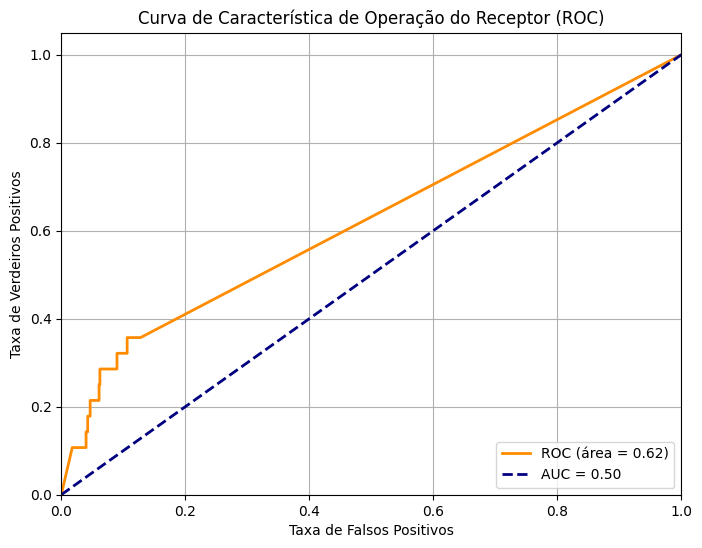

In [15]:
best_params_overall = {'smote__k_neighbors': 7, 'imputer__strategy': 'median', 'classifier__weights': 'distance', 'classifier__p': 1, 'classifier__n_neighbors': 7, 'classifier__metric': 'minkowski'}
final_pipeline_knn = ImbPipeline(pipeline_steps_knn)
final_pipeline_knn.set_params(**best_params_overall) # aplicando os melhores hiperparametros

final_pipeline_knn.fit(X_train, y_train)

y_pred_proba = final_pipeline_knn.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='AUC = 0.50')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdeiros Positivos')
plt.title('Curva de Característica de Operação do Receptor (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Árvore de Decisão

In [16]:
pipeline_steps_tree = [
    ('imputer', SimpleImputer()), # Imputando dados 
    ('smote', SMOTE(random_state = 5)), # Reamostragem 
    ('scaler', StandardScaler()),       
    ('classifier', DecisionTreeClassifier()) # Modelo 
]

pipeline_tree = ImbPipeline(pipeline_steps_tree)

In [19]:
tree_param_dist = {
    'imputer__strategy': ['mean', 'median'],

    # parametros do SMOTE
    # numero de vizinhos para gerar amostras
    'smote__k_neighbors': [3,5,7,9],

    # parametros da arvore
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 5, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__class_weight': ['balanced']
}

In [62]:
best_score_overall_tree = -1
best_params_overall_tree = None
historicos_tree_cv = []


for c in range(1, 21): 
    print(f'Execução de RandomizedSearchCV para Decision Tree: {c}/20')
    current_tree_cv = RandomizedSearchCV(
        estimator=pipeline_tree,
        param_distributions=tree_param_dist,
        n_iter=5, 
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=c), 
        scoring='f1',
        verbose=0,
        n_jobs=-1
    )
    current_tree_cv.fit(X_train, y_train)

    resultados_tree_iter = current_tree_cv.cv_results_
    historico_tree_df_iter = pd.DataFrame({
        'params': resultados_tree_iter['params'],
        'mean_test_score': resultados_tree_iter['mean_test_score'],
        'std_test_score': resultados_tree_iter['std_test_score'],
        'rank_test_score': resultados_tree_iter['rank_test_score']
    })
    historico_tree_df_iter['run_iteration'] = c
    historicos_tree_cv.append(historico_tree_df_iter)

    if current_tree_cv.best_score_ > best_score_overall_tree:
        best_score_overall_tree = current_tree_cv.best_score_
        best_params_overall_tree = current_tree_cv.best_params_


all_historico_tree_df = pd.concat(historicos_tree_cv, ignore_index=True)

print("\n--- Resultados Finais da Busca de Hiperparâmetros para Decision Tree ---")
print(f"Melhor F1-score encontrado (validação cruzada): {best_score_overall_tree:.4f}")
print(f"Melhores Hiperparâmetros globais: {best_params_overall_tree}")


Execução de RandomizedSearchCV para Decision Tree: 1/20
Execução de RandomizedSearchCV para Decision Tree: 2/20
Execução de RandomizedSearchCV para Decision Tree: 3/20
Execução de RandomizedSearchCV para Decision Tree: 4/20
Execução de RandomizedSearchCV para Decision Tree: 5/20
Execução de RandomizedSearchCV para Decision Tree: 6/20
Execução de RandomizedSearchCV para Decision Tree: 7/20
Execução de RandomizedSearchCV para Decision Tree: 8/20
Execução de RandomizedSearchCV para Decision Tree: 9/20
Execução de RandomizedSearchCV para Decision Tree: 10/20
Execução de RandomizedSearchCV para Decision Tree: 11/20
Execução de RandomizedSearchCV para Decision Tree: 12/20
Execução de RandomizedSearchCV para Decision Tree: 13/20
Execução de RandomizedSearchCV para Decision Tree: 14/20
Execução de RandomizedSearchCV para Decision Tree: 15/20
Execução de RandomizedSearchCV para Decision Tree: 16/20
Execução de RandomizedSearchCV para Decision Tree: 17/20
Execução de RandomizedSearchCV para Deci

In [63]:
all_historico_tree_df

,params,mean_test_score,std_test_score,rank_test_score,run_iteration
0,"{'smote__k_neighbors': 7, 'imputer__strategy':...",0.134115,0.071882,1,1
1,"{'smote__k_neighbors': 5, 'imputer__strategy':...",0.087297,0.053816,3,1
2,"{'smote__k_neighbors': 5, 'imputer__strategy':...",0.043299,0.036251,5,1
3,"{'smote__k_neighbors': 9, 'imputer__strategy':...",0.080211,0.040132,4,1
4,"{'smote__k_neighbors': 3, 'imputer__strategy':...",0.131553,0.068859,2,1
...,...,...,...,...,...
95,"{'smote__k_neighbors': 9, 'imputer__strategy':...",0.072278,0.033640,5,20
96,"{'smote__k_neighbors': 5, 'imputer__strategy':...",0.088297,0.047809,3,20
97,"{'smote__k_neighbors': 5, 'imputer__strategy':...",0.077906,0.027634,4,20
98,"{'smote__k_neighbors': 5, 'imputer__strategy':...",0.110537,0.049816,1,20


In [64]:
final_pipeline_tree = ImbPipeline(pipeline_steps_tree) 
final_pipeline_tree.set_params(**best_params_overall_tree) 

final_pipeline_tree.fit(X_train, y_train)

test_accuracy_final_tree = final_pipeline_tree.score(X_test, y_test)
print(f"Acurácia final no conjunto de teste: {test_accuracy_final_tree:.4f}")

y_pred_test_final_tree = final_pipeline_tree.predict(X_test)

print(f"Valor do f1_score (macro) final: {f1_score(y_test, y_pred_test_final_tree, average='macro'):.4f}")
print(f"Precisão do modelo (macro) final: {precision_score(y_test, y_pred_test_final_tree, average='macro'):.4f}")
print(f"Valor do recall do modelo (macro) final: {recall_score(y_test, y_pred_test_final_tree, average='macro'):.4f}")

print("\nRelatório de Classificação no conjunto de teste (Modelo Final Decision Tree):")
print(classification_report(y_test, y_pred_test_final_tree))

print("\nMatriz de Confusão no conjunto de teste (Modelo Final Decision Tree):")
print(confusion_matrix(y_test, y_pred_test_final_tree))

# Verificar se o classificador final tem predict_proba (Decision Tree geralmente tem)
if hasattr(final_pipeline_tree.named_steps['classifier'], 'predict_proba'):
    y_pred_proba_final_tree = final_pipeline_tree.predict_proba(X_test)[:, 1]
    print(f"ROC AUC Score no conjunto de teste (Modelo Final Decision Tree): {roc_auc_score(y_test, y_pred_proba_final_tree):.4f}")

Acurácia final no conjunto de teste: 0.9298
Valor do f1_score (macro) final: 0.5526
Precisão do modelo (macro) final: 0.5389
Valor do recall do modelo (macro) final: 0.6312

Relatório de Classificação no conjunto de teste (Modelo Final Decision Tree):
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1525
           1       0.09      0.32      0.14        28

    accuracy                           0.93      1553
   macro avg       0.54      0.63      0.55      1553
weighted avg       0.97      0.93      0.95      1553


Matriz de Confusão no conjunto de teste (Modelo Final Decision Tree):
[[1435   90]
 [  19    9]]
ROC AUC Score no conjunto de teste (Modelo Final Decision Tree): 0.7243


Curva AOC

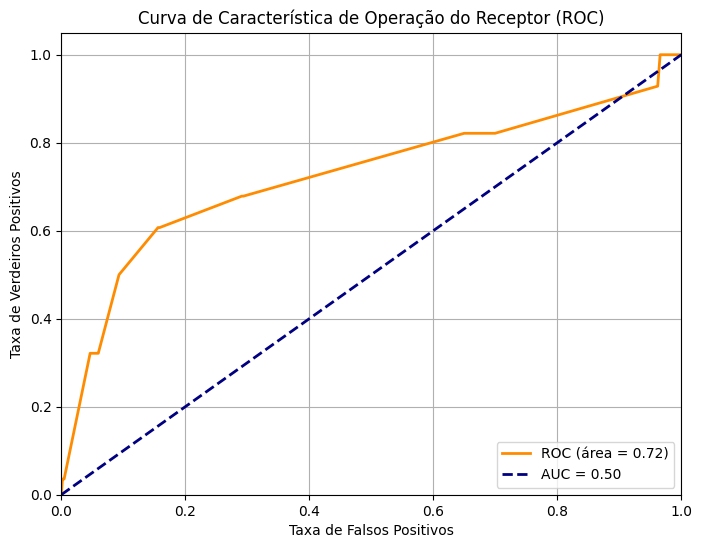

In [17]:
best_params_overall = {'smote__k_neighbors': 9, 'imputer__strategy': 'median', 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 5, 'classifier__criterion': 'entropy', 'classifier__class_weight': 'balanced'}
final_pipeline_tree = ImbPipeline(pipeline_steps_tree)
final_pipeline_tree.set_params(**best_params_overall) 

final_pipeline_tree.fit(X_train, y_train)

y_pred_proba = final_pipeline_tree.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='AUC = 0.50')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdeiros Positivos')
plt.title('Curva de Característica de Operação do Receptor (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# SVM

In [19]:
pipeline_steps_svm = [
    ('imputer', SimpleImputer()), # Imputando dados 
    ('smote', SMOTE(random_state = 5)), # Reamostragem 
    ('scaler', StandardScaler()),       
    ('classifier', SVC()) # Modelo 
]

pipeline_svm = ImbPipeline(pipeline_steps_svm)

In [25]:
svm_param_dist = {
    'imputer__strategy': ['mean', 'median'],

    # parametros do SMOTE
    # numero de vizinhos para gerar amostras
    'smote__k_neighbors': [3,5,7,9],

    # parametros da arvore
    'classifier__C' : [0.01,0.1,1],
    'classifier__kernel' : ['poly', 'rbf', 'sigmoid'],
    'classifier__gamma' : [0.1,1],
    'classifier__degree': [3,5],
    'classifier__class_weight': ['balanced']
}

In [68]:
best_score_overall_svm = -1
best_params_overall_svm = None
historicos_svm_cv = []

for c in range(1, 21): # Rodará 20 vezes, cada vez com n_iter=5
    print(f'Execução de RandomizedSearchCV para SVM: {c}/20')
    current_svm_cv = RandomizedSearchCV(
        estimator=pipeline_svm,
        param_distributions=svm_param_dist,
        n_iter=5, # Número de combinações a testar em CADA execução do RandomizedSearchCV
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=c), # Use c para variar o random_state do CV
        scoring='f1', # Pode ser 'f1_macro' se for multiclasse e você quiser média macro
        verbose=0,
        n_jobs=-1
    )
    current_svm_cv.fit(X_train, y_train)

    resultados_svm_iter = current_svm_cv.cv_results_
    historico_svm_df_iter = pd.DataFrame({
        'params': resultados_svm_iter['params'],
        'mean_test_score': resultados_svm_iter['mean_test_score'],
        'std_test_score': resultados_svm_iter['std_test_score'],
        'rank_test_score': resultados_svm_iter['rank_test_score']
    })
    historico_svm_df_iter['run_iteration'] = c
    historicos_svm_cv.append(historico_svm_df_iter)


    # Verifica se esta execução encontrou um modelo melhor
    if current_svm_cv.best_score_ > best_score_overall_svm:
        best_score_overall_svm = current_svm_cv.best_score_
        best_params_overall_svm = current_svm_cv.best_params_


all_historico_svm_df = pd.concat(historicos_svm_cv, ignore_index=True)

print("\n--- Resultados Finais da Busca de Hiperparâmetros para SVM ---")
print(f"Melhor F1-score encontrado (validação cruzada): {best_score_overall_svm:.4f}")
print(f"Melhores Hiperparâmetros globais: {best_params_overall_svm}")


Execução de RandomizedSearchCV para SVM: 1/20
Execução de RandomizedSearchCV para SVM: 2/20
Execução de RandomizedSearchCV para SVM: 3/20
Execução de RandomizedSearchCV para SVM: 4/20
Execução de RandomizedSearchCV para SVM: 5/20
Execução de RandomizedSearchCV para SVM: 6/20
Execução de RandomizedSearchCV para SVM: 7/20
Execução de RandomizedSearchCV para SVM: 8/20
Execução de RandomizedSearchCV para SVM: 9/20
Execução de RandomizedSearchCV para SVM: 10/20
Execução de RandomizedSearchCV para SVM: 11/20
Execução de RandomizedSearchCV para SVM: 12/20
Execução de RandomizedSearchCV para SVM: 13/20
Execução de RandomizedSearchCV para SVM: 14/20
Execução de RandomizedSearchCV para SVM: 15/20
Execução de RandomizedSearchCV para SVM: 16/20
Execução de RandomizedSearchCV para SVM: 17/20
Execução de RandomizedSearchCV para SVM: 18/20
Execução de RandomizedSearchCV para SVM: 19/20
Execução de RandomizedSearchCV para SVM: 20/20

--- Resultados Finais da Busca de Hiperparâmetros para SVM ---
Melho

In [70]:
final_pipeline_svm = ImbPipeline(pipeline_steps_svm) 
final_pipeline_svm.set_params(**best_params_overall_svm) 

final_pipeline_svm.fit(X_train, y_train)


test_accuracy_final_svm = final_pipeline_svm.score(X_test, y_test)
print(f"Acurácia final no conjunto de teste: {test_accuracy_final_svm:.4f}")

y_pred_test_final_svm = final_pipeline_svm.predict(X_test)

print(f"Valor do f1_score (macro) final: {f1_score(y_test, y_pred_test_final_svm, average='macro'):.4f}")
print(f"Precisão do modelo (macro) final: {precision_score(y_test, y_pred_test_final_svm, average='macro'):.4f}")
print(f"Valor do recall do modelo (macro) final: {recall_score(y_test, y_pred_test_final_svm, average='macro'):.4f}")

print("\nRelatório de Classificação no conjunto de teste (Modelo Final SVM):")
print(classification_report(y_test, y_pred_test_final_svm))

print("\nMatriz de Confusão no conjunto de teste (Modelo Final SVM):")
print(confusion_matrix(y_test, y_pred_test_final_svm))

if hasattr(final_pipeline_svm.named_steps['classifier'], 'predict_proba'):
    y_pred_proba_final_svm = final_pipeline_svm.predict_proba(X_test)[:, 1]
    print(f"ROC AUC Score no conjunto de teste (Modelo Final SVM): {roc_auc_score(y_test, y_pred_proba_final_svm):.4f}")
else:
    print("O classificador SVM não possui predict_proba para calcular o ROC AUC Score.")


Acurácia final no conjunto de teste: 0.9156
Valor do f1_score (macro) final: 0.5383
Precisão do modelo (macro) final: 0.5306
Valor do recall do modelo (macro) final: 0.6240

Relatório de Classificação no conjunto de teste (Modelo Final SVM):
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1525
           1       0.07      0.32      0.12        28

    accuracy                           0.92      1553
   macro avg       0.53      0.62      0.54      1553
weighted avg       0.97      0.92      0.94      1553


Matriz de Confusão no conjunto de teste (Modelo Final SVM):
[[1413  112]
 [  19    9]]
O classificador SVM não possui predict_proba para calcular o ROC AUC Score.


# LVQ

In [24]:
pipeline_steps_glvq = [
    ('imputer', SimpleImputer()),
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', GLVQ(random_state=42)) # Classificador GLVQ
]

pipeline_glvq = ImbPipeline(pipeline_steps_glvq)

In [31]:
glvq_param_dist = {
    'imputer__strategy': ['mean', 'median'],
    'smote__k_neighbors': [3, 5, 7, 9],

    'classifier__distance_type': ["euclidean"],
    'classifier__prototype_n_per_class': [1, 2, 3, 4, 5],
}

In [71]:
best_score_overall_glvq = -1
best_params_overall_glvq = None
historicos_glvq_cv = []

for c in range(1, 21): 
    print(f'Execução de RandomizedSearchCV para GLVQ: {c}/20')
    current_glvq_cv = RandomizedSearchCV(
        estimator=pipeline_glvq,
        param_distributions=glvq_param_dist,
        n_iter=5, 
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=c), 
        scoring='f1', 
        verbose=0,
        n_jobs=-1
    )
    current_glvq_cv.fit(X_train, y_train)

    resultados_glvq_iter = current_glvq_cv.cv_results_
    historico_glvq_df_iter = pd.DataFrame({
        'params': resultados_glvq_iter['params'],
        'mean_test_score': resultados_glvq_iter['mean_test_score'],
        'std_test_score': resultados_glvq_iter['std_test_score'],
        'rank_test_score': resultados_glvq_iter['rank_test_score']
    })
    historico_glvq_df_iter['run_iteration'] = c
    historicos_glvq_cv.append(historico_glvq_df_iter)


    if current_glvq_cv.best_score_ > best_score_overall_glvq:
        best_score_overall_glvq = current_glvq_cv.best_score_
        best_params_overall_glvq = current_glvq_cv.best_params_


all_historico_glvq_df = pd.concat(historicos_glvq_cv, ignore_index=True)

print("\n--- Resultados Finais da Busca de Hiperparâmetros para GLVQ ---")
print(f"Melhor F1-score encontrado (validação cruzada): {best_score_overall_glvq:.4f}")
print(f"Melhores Hiperparâmetros globais: {best_params_overall_glvq}")

Execução de RandomizedSearchCV para GLVQ: 1/20
Execução de RandomizedSearchCV para GLVQ: 2/20
Execução de RandomizedSearchCV para GLVQ: 3/20
Execução de RandomizedSearchCV para GLVQ: 4/20
Execução de RandomizedSearchCV para GLVQ: 5/20
Execução de RandomizedSearchCV para GLVQ: 6/20
Execução de RandomizedSearchCV para GLVQ: 7/20
Execução de RandomizedSearchCV para GLVQ: 8/20
Execução de RandomizedSearchCV para GLVQ: 9/20
Execução de RandomizedSearchCV para GLVQ: 10/20
Execução de RandomizedSearchCV para GLVQ: 11/20
Execução de RandomizedSearchCV para GLVQ: 12/20
Execução de RandomizedSearchCV para GLVQ: 13/20
Execução de RandomizedSearchCV para GLVQ: 14/20
Execução de RandomizedSearchCV para GLVQ: 15/20
Execução de RandomizedSearchCV para GLVQ: 16/20
Execução de RandomizedSearchCV para GLVQ: 17/20
Execução de RandomizedSearchCV para GLVQ: 18/20
Execução de RandomizedSearchCV para GLVQ: 19/20
Execução de RandomizedSearchCV para GLVQ: 20/20

--- Resultados Finais da Busca de Hiperparâmetro

In [72]:
final_pipeline_glvq = ImbPipeline(pipeline_steps_glvq) 
final_pipeline_glvq.set_params(**best_params_overall_glvq) 

final_pipeline_glvq.fit(X_train, y_train)

test_accuracy_final_glvq = final_pipeline_glvq.score(X_test, y_test)
print(f"Acurácia final no conjunto de teste: {test_accuracy_final_glvq:.4f}")

y_pred_test_final_glvq = final_pipeline_glvq.predict(X_test)

print(f"Valor do f1_score (macro) final: {f1_score(y_test, y_pred_test_final_glvq, average='macro'):.4f}")
print(f"Precisão do modelo (macro) final: {precision_score(y_test, y_pred_test_final_glvq, average='macro'):.4f}")
print(f"Valor do recall do modelo (macro) final: {recall_score(y_test, y_pred_test_final_glvq, average='macro'):.4f}")

print("\nRelatório de Classificação no conjunto de teste (Modelo Final GLVQ):")
print(classification_report(y_test, y_pred_test_final_glvq))

print("\nMatriz de Confusão no conjunto de teste (Modelo Final GLVQ):")
print(confusion_matrix(y_test, y_pred_test_final_glvq))

# O GLVQ da biblioteca sklvq não possui predict_proba
if hasattr(final_pipeline_glvq.named_steps['classifier'], 'predict_proba'):
    y_pred_proba_final_glvq = final_pipeline_glvq.predict_proba(X_test)[:, 1]
    print(f"ROC AUC Score no conjunto de teste (Modelo Final GLVQ): {roc_auc_score(y_test, y_pred_proba_final_glvq):.4f}")
else:
    print("O classificador GLVQ não possui predict_proba para calcular o ROC AUC Score.")

Acurácia final no conjunto de teste: 0.9556
Valor do f1_score (macro) final: 0.5627
Precisão do modelo (macro) final: 0.5493
Valor do recall do modelo (macro) final: 0.5917

Relatório de Classificação no conjunto de teste (Modelo Final GLVQ):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1525
           1       0.11      0.21      0.15        28

    accuracy                           0.96      1553
   macro avg       0.55      0.59      0.56      1553
weighted avg       0.97      0.96      0.96      1553


Matriz de Confusão no conjunto de teste (Modelo Final GLVQ):
[[1478   47]
 [  22    6]]
ROC AUC Score no conjunto de teste (Modelo Final GLVQ): 0.6932


Curva AOC

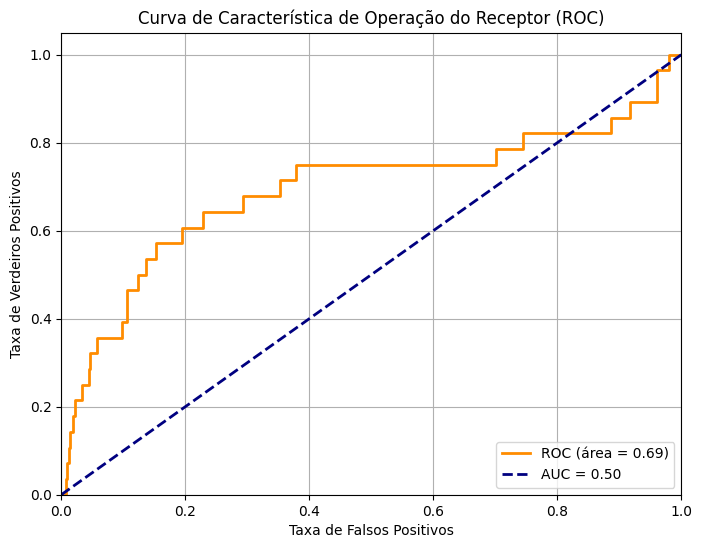

In [25]:
best_params_overall = {'smote__k_neighbors': 3, 'imputer__strategy': 'mean', 'classifier__prototype_n_per_class': 1, 'classifier__distance_type': 'euclidean'}
final_pipeline_glvq = ImbPipeline(pipeline_steps_glvq)
final_pipeline_glvq.set_params(**best_params_overall) 

final_pipeline_glvq.fit(X_train, y_train)

y_pred_proba = final_pipeline_glvq.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='AUC = 0.50')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdeiros Positivos')
plt.title('Curva de Característica de Operação do Receptor (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Random Forest

In [21]:
pipeline_steps_forest = [
    ('imputer', SimpleImputer()), # Imputando dados 
    ('smote', SMOTE(random_state = 5)), # Reamostragem 
    ('scaler', StandardScaler()),       
    ('classifier', RandomForestClassifier()) # Modelo 
]

pipeline_forest = ImbPipeline(pipeline_steps_forest)

In [39]:
forest_param_dist = {
    'imputer__strategy': ['mean', 'median'],

    # parametros do SMOTE
    # numero de vizinhos para gerar amostras
    'smote__k_neighbors': [3,5,7,9],

    # parametros da arvore
    'classifier__n_estimators': [100, 200, 300],  
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__class_weight': ['balanced']
}

In [65]:
best_score_overall_forest = -1
best_params_overall_forest = None
historicos_forest_cv = []

for c in range(1, 21):
    print(f'Execução de RandomizedSearchCV para Random Forest: {c}/20')
    current_forest_cv = RandomizedSearchCV(
        estimator=pipeline_forest,
        param_distributions=forest_param_dist,
        n_iter=5, 
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=c), 
        scoring='f1', 
        verbose=0,
        n_jobs=-1
    )
    current_forest_cv.fit(X_train, y_train)

    resultados_forest_iter = current_forest_cv.cv_results_
    historico_forest_df_iter = pd.DataFrame({
        'params': resultados_forest_iter['params'],
        'mean_test_score': resultados_forest_iter['mean_test_score'],
        'std_test_score': resultados_forest_iter['std_test_score'],
        'rank_test_score': resultados_forest_iter['rank_test_score']
    })
    historico_forest_df_iter['run_iteration'] = c
    historicos_forest_cv.append(historico_forest_df_iter)


    if current_forest_cv.best_score_ > best_score_overall_forest:
        best_score_overall_forest = current_forest_cv.best_score_
        best_params_overall_forest = current_forest_cv.best_params_


all_historico_forest_df = pd.concat(historicos_forest_cv, ignore_index=True)

print("\n--- Resultados Finais da Busca de Hiperparâmetros para Random Forest ---")
print(f"Melhor F1-score encontrado (validação cruzada): {best_score_overall_forest:.4f}")
print(f"Melhores Hiperparâmetros globais: {best_params_overall_forest}")

Execução de RandomizedSearchCV para Random Forest: 1/20
Execução de RandomizedSearchCV para Random Forest: 2/20
Execução de RandomizedSearchCV para Random Forest: 3/20
Execução de RandomizedSearchCV para Random Forest: 4/20
Execução de RandomizedSearchCV para Random Forest: 5/20
Execução de RandomizedSearchCV para Random Forest: 6/20
Execução de RandomizedSearchCV para Random Forest: 7/20
Execução de RandomizedSearchCV para Random Forest: 8/20
Execução de RandomizedSearchCV para Random Forest: 9/20
Execução de RandomizedSearchCV para Random Forest: 10/20
Execução de RandomizedSearchCV para Random Forest: 11/20
Execução de RandomizedSearchCV para Random Forest: 12/20
Execução de RandomizedSearchCV para Random Forest: 13/20
Execução de RandomizedSearchCV para Random Forest: 14/20
Execução de RandomizedSearchCV para Random Forest: 15/20
Execução de RandomizedSearchCV para Random Forest: 16/20
Execução de RandomizedSearchCV para Random Forest: 17/20
Execução de RandomizedSearchCV para Rand

In [66]:
all_historico_forest_df

,params,mean_test_score,std_test_score,rank_test_score,run_iteration
0,"{'smote__k_neighbors': 3, 'imputer__strategy':...",0.027619,0.033860,5,1
1,"{'smote__k_neighbors': 5, 'imputer__strategy':...",0.067943,0.060628,2,1
2,"{'smote__k_neighbors': 5, 'imputer__strategy':...",0.164161,0.075243,1,1
3,"{'smote__k_neighbors': 7, 'imputer__strategy':...",0.049581,0.047731,3,1
4,"{'smote__k_neighbors': 5, 'imputer__strategy':...",0.043987,0.041549,4,1
...,...,...,...,...,...
95,"{'smote__k_neighbors': 9, 'imputer__strategy':...",0.024242,0.048485,5,20
96,"{'smote__k_neighbors': 5, 'imputer__strategy':...",0.048941,0.025019,3,20
97,"{'smote__k_neighbors': 9, 'imputer__strategy':...",0.063809,0.038101,2,20
98,"{'smote__k_neighbors': 5, 'imputer__strategy':...",0.038550,0.031742,4,20


In [67]:
final_pipeline_forest = ImbPipeline(pipeline_steps_forest) 
final_pipeline_forest.set_params(**best_params_overall_forest) 

final_pipeline_forest.fit(X_train, y_train)

test_accuracy_final_forest = final_pipeline_forest.score(X_test, y_test)
print(f"Acurácia final no conjunto de teste: {test_accuracy_final_forest:.4f}")

y_pred_test_final_forest = final_pipeline_forest.predict(X_test)

print(f"Valor do f1_score (macro) final: {f1_score(y_test, y_pred_test_final_forest, average='macro'):.4f}")
print(f"Precisão do modelo (macro) final: {precision_score(y_test, y_pred_test_final_forest, average='macro'):.4f}")
print(f"Valor do recall do modelo (macro) final: {recall_score(y_test, y_pred_test_final_forest, average='macro'):.4f}")

print("\nRelatório de Classificação no conjunto de teste (Modelo Final Random Forest):")
print(classification_report(y_test, y_pred_test_final_forest))

print("\nMatriz de Confusão no conjunto de teste (Modelo Final Random Forest):")
print(confusion_matrix(y_test, y_pred_test_final_forest))

# RandomForestClassifier possui predict_proba por padrão
if hasattr(final_pipeline_forest.named_steps['classifier'], 'predict_proba'):
    y_pred_proba_final_forest = final_pipeline_forest.predict_proba(X_test)[:, 1]
    print(f"ROC AUC Score no conjunto de teste (Modelo Final Random Forest): {roc_auc_score(y_test, y_pred_proba_final_forest):.4f}")

print("\nFim da execução para Random Forest.")


Acurácia final no conjunto de teste: 0.9131
Valor do f1_score (macro) final: 0.5526
Precisão do modelo (macro) final: 0.5402
Valor do recall do modelo (macro) final: 0.6753

Relatório de Classificação no conjunto de teste (Modelo Final Random Forest):
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1525
           1       0.09      0.43      0.15        28

    accuracy                           0.91      1553
   macro avg       0.54      0.68      0.55      1553
weighted avg       0.97      0.91      0.94      1553


Matriz de Confusão no conjunto de teste (Modelo Final Random Forest):
[[1406  119]
 [  16   12]]
ROC AUC Score no conjunto de teste (Modelo Final Random Forest): 0.7683

Fim da execução para Random Forest.


Curva AOC

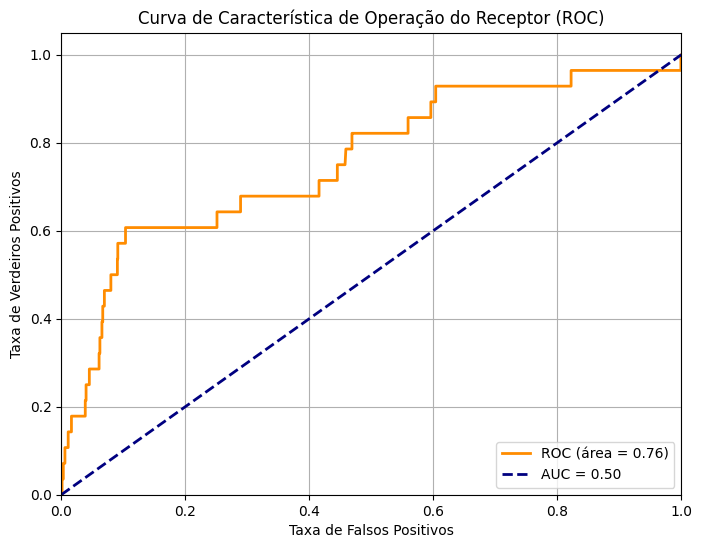

In [22]:
best_params_overall = {'smote__k_neighbors': 9, 'imputer__strategy': 'mean', 'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 5, 'classifier__criterion': 'gini', 'classifier__class_weight': 'balanced'}
final_pipeline_forest = ImbPipeline(pipeline_steps_forest)
final_pipeline_forest.set_params(**best_params_overall) 

final_pipeline_forest.fit(X_train, y_train)

y_pred_proba = final_pipeline_forest.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='AUC = 0.50')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdeiros Positivos')
plt.title('Curva de Característica de Operação do Receptor (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()